In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import random
import csv
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

# Definizione funzioni

In [2]:
def RMSE_Loss(actual, predicted):
    """Root Mean Squared Error"""
    return torch.sqrt(torch.mean(torch.square(actual - predicted)))

In [3]:
def getRemoteDataset():
    return pd.read_csv('https://raw.githubusercontent.com/Uniba-dev-projects/forecasting-framework/synthetic_dataset_analysis/synthetic_dataset/synthetic_dataset.csv')    

In [4]:
def extractDataframeAndSeries(key, dataset):
    df = dataset[[key]]
    df = df.rename(columns={key: "t"}).reset_index()
    df.series = df.t.str.replace(",",".", regex=True).astype(float)
    return df, df.series.squeeze().dropna()

In [5]:
def calculateLoss(y, y_predicted):
    loss = []
    for i in range(len(y)):
        loss.append(abs(y[i]-y_predicted[i]))
    return loss

In [6]:
def showPerformanceGraph(label, portion, y_train, y_test, y_predicted_train, y_predicted_test, loss_train, loss_test, rmse_train, rmse_test):
    total = len(y_train) + len(y_test)
    plt.figure(figsize=(30,5))
    plt.subplot(1, 3, 1)
    plt.plot(np.arange(0, total, 1), np.concatenate((y_train, y_test), axis=0))
    plt.plot(np.arange(0, total, 1), np.concatenate((y_predicted_train, y_predicted_test), axis=0))
    plt.legend(["Series", "Predicted", "Train and test set splitter"])

    plt.subplot(1, 3, 2)
    plt.plot(np.arange(0, total, 1), np.concatenate((loss_train, loss_test), axis=0))
    plt.legend(["Loss", "Train and test set splitter"])

    plt.subplot(1, 3, 3)
    plt.plot(rmse_train)
    plt.plot(rmse_test)
    plt.title("Last RMSE Train = "+str(rmse_train[-1])+"\n Last RMSE Test = "+str(rmse_test[-1]))
    plt.legend(["RMSE Train", "RMSE Test"])
    
    plt.suptitle(label)

# Inizializzazione e Visualizzazione Serie Temporali Sintentiche

In [7]:
dataset = getRemoteDataset()
_, series1 = extractDataframeAndSeries('y1(t) = t/1000 = y1(t-1)+0.001', dataset)
_, series2 = extractDataframeAndSeries('y2(t)=y2(t-1)*0.999', dataset)
_, series3 = extractDataframeAndSeries('y3(t)=y1(t)+y2(t)', dataset)
_, series4 = extractDataframeAndSeries('y4(t) = y4(t-1)-0.001', dataset)
_, series5 = extractDataframeAndSeries('y5(t)=y1(t)*t%2+y4(t)*(1-t%2)', dataset)
_, series6 = extractDataframeAndSeries('y6(t)=sin(t)', dataset)

# DatasetManager e Inizializzazione Long Short Term Memory
DatasetManager restituisce da una serie temporale un pandas.DataFrame definendo il numero di feature e il numero di variabili target.

In [8]:
def min_max_transform(series):
  series_temp = np.copy(series)
  for i in range(len(series_temp)):
    series_temp[i] = (series_temp[i] - np.max(series))/(np.max(series)-np.min(series)) + 1
  return series_temp

In [9]:
class DatasetManager():

    def __getPandasFromNumpySeries(self, series, features_sequences=1, target_sequences=1, offset=0):

        dfTemp = pd.DataFrame({"ref": series})
        dfTemp.ref = dfTemp.ref.astype(float)
        for i in range(target_sequences):
            dfTemp['t+'+str(target_sequences-i)] = dfTemp.ref.shift(i)

        dfTemp['t'] = dfTemp.ref.shift(target_sequences)

        for j in range(features_sequences-1):
            dfTemp['t-'+str(j+1)] = dfTemp.ref.shift(target_sequences+j+1)

        dfTemp.drop(columns=["ref"], inplace=True)
        dropLine = features_sequences+target_sequences-1

        if(offset > 0):
            dfTemp['t'] = dfTemp['t'].shift(offset)
            for i in range(features_sequences-1):
                dfTemp['t-'+str(i+1)] = dfTemp['t-'+str(i+1)].shift(offset)
        
        dfTemp.drop(np.arange(0, dropLine+offset), inplace=True)
    
        return dfTemp[dfTemp.columns[::-1]].reset_index().drop(columns=["index"])
    
    def __getScaledDataFrame(self, series):
        return pd.Series(min_max_transform(series.to_numpy()))

    def __init__(self, sequences, features_sequences=1, target_sequences=1, offset=0, portion=0.8):
        self.sequences = self.__getScaledDataFrame(sequences)
        self.features_sequences = features_sequences
        self.target_sequences = target_sequences
        self.offset = offset
        self.portion = portion
        self.df = self.__getPandasFromNumpySeries(sequences, features_sequences, target_sequences, offset)

    def __len__(self):
        return len(self.sequences)

    def __get_x_y(self):
      return self.df[self.df.columns[0:self.features_sequences]].to_numpy(), self.df[self.df.columns[self.features_sequences:]].to_numpy()


    def __train_and_test_set__(self):
      x, y = self.__get_x_y()
      X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.8)
      return torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

    def __get_entire_series__(self):
      x, y = self.__get_x_y()
      return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
 


In [10]:
class CNN_Linear_Predictor(nn.Module):
    def __init__(self, n_inp, l_1 = 180, conv1_out = 6, conv1_kernel = 36, conv2_kernel = 12, n_out = 1):
        super(CNN_Linear_Predictor, self).__init__()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv1 = nn.Conv1d(
            in_channels = 1,
            out_channels = conv1_out,
            kernel_size = conv1_kernel,
            padding = conv1_kernel - 1
        )
        self.conv2 = nn.Conv1d(
            in_channels = conv1_out,
            out_channels = conv1_out * 2,
            kernel_size = conv2_kernel,
            padding = conv2_kernel - 1
        )
        feature_tensor = self.fe_stack(torch.Tensor([[0]*n_inp]))
        self.lin1 = nn.Linear(feature_tensor.size()[1], l_1)
        self.lin2 = nn.Linear(l_1, n_out)
        
    def fe_stack(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = x.flatten(start_dim = 1)
        return x

    def dm_stack(self, x):
        x1 = F.relu(self.lin1(x))
        y = self.lin2(x1)
        return y

    def forward(self, x):
        x = self.fe_stack(x)
        y = self.dm_stack(x)
        return y

In [27]:
def executeCNN_Lin(label, series, feature_sequences=1, target_sequences=1, portion=0.8, offset=0, num_epochs=25):
    dataset = DatasetManager(
        series,
        features_sequences=feature_sequences,
        target_sequences=target_sequences,
        portion=portion,
        offset=offset
    )
    X_train, X_test, y_train, y_test = dataset.__train_and_test_set__()

    cnnLin = CNN_Linear_Predictor(feature_sequences)
    optimizer = optim.Adam(cnnLin.parameters(), lr=0.001)

    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)

    for t in range(num_epochs):
        y_train_pred = cnnLin(X_train)
        loss = RMSE_Loss(y_train, y_train_pred)

        cnnLin.eval()
        with torch.no_grad():
            y_test_pred = cnnLin(X_test)
            test_loss = RMSE_Loss(y_test, y_test_pred)
            test_hist[t] = test_loss.item()

        if(t%50 == 0):
          print(f'Epoch {t} train loss:{loss.item()} test loss: {test_loss.item()}')
        
        train_hist[t] = loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    showPerformanceGraph(
        label = label,
        portion=portion,
        y_train=y_train.squeeze(),
        y_test=y_test.squeeze(),
        y_predicted_train=y_train_pred.detach().numpy().flatten(),
        y_predicted_test=y_test_pred.detach().numpy().flatten(),
        loss_train=calculateLoss(y_train.squeeze(), y_train_pred.detach().numpy().flatten()),
        loss_test=calculateLoss(y_test.squeeze(), y_test_pred.detach().numpy().flatten()),
        rmse_train=train_hist,
        rmse_test=test_hist
    )

    x_series, y_series = dataset.__get_entire_series__()
    cnnLin.eval()
    with torch.no_grad():
        yhat_series = cnnLin(x_series)
        plt.figure(figsize=(25,5))
        plt.plot(y_series.detach().numpy())
        plt.plot(yhat_series.detach().numpy())
        plt.legend(["True", "Predicted"])


# Execute CNN-SemiLinear

In [42]:
features_length = 5 #Default 1 (Sostituire i valori per gli esperimenti)
offset = 3 #Default 0 (Sostituire i valori per gli esperimenti)
portion_train_test = 0.8 #Default 0.8 (Sostituire i valori per gli esperimenti)
num_epochs = 300

Epoch 0 train loss:0.5668807029724121 test loss: 0.5478337407112122
Epoch 50 train loss:0.029283465817570686 test loss: 0.030301310122013092
Epoch 100 train loss:0.010261936113238335 test loss: 0.010375258512794971
Epoch 150 train loss:0.0013882559724152088 test loss: 0.0015340157551690936
Epoch 200 train loss:0.01852998323738575 test loss: 0.01794559694826603
Epoch 250 train loss:0.007175056263804436 test loss: 0.006997981108725071


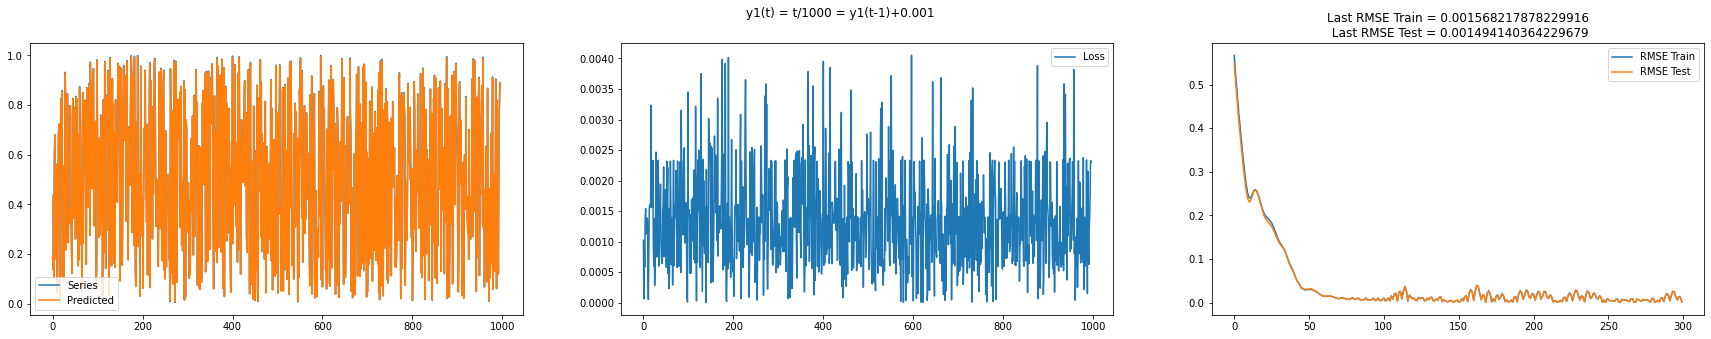

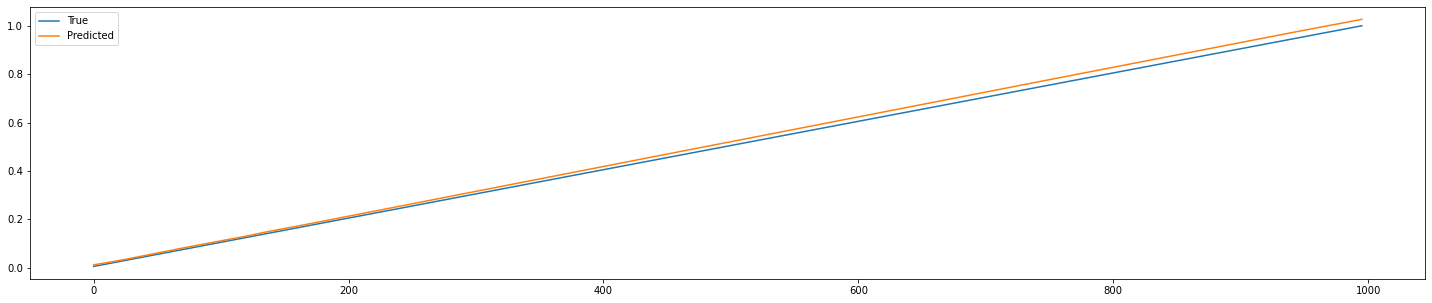

In [43]:
executeCNN_Lin("y1(t) = t/1000 = y1(t-1)+0.001", series1, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs)

Epoch 0 train loss:0.6243872046470642 test loss: 0.5973111987113953
Epoch 50 train loss:0.05220422521233559 test loss: 0.05626944079995155
Epoch 100 train loss:0.019778655841946602 test loss: 0.018926776945590973
Epoch 150 train loss:0.004089938011020422 test loss: 0.0039038057439029217
Epoch 200 train loss:0.001960482681170106 test loss: 0.0019489979604259133
Epoch 250 train loss:0.002309090457856655 test loss: 0.002245604293420911


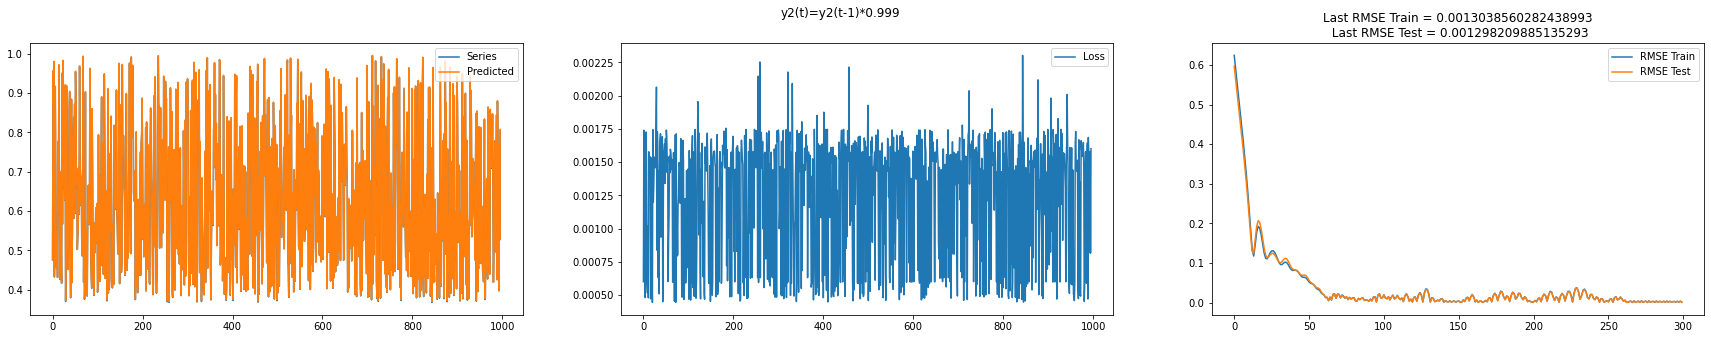

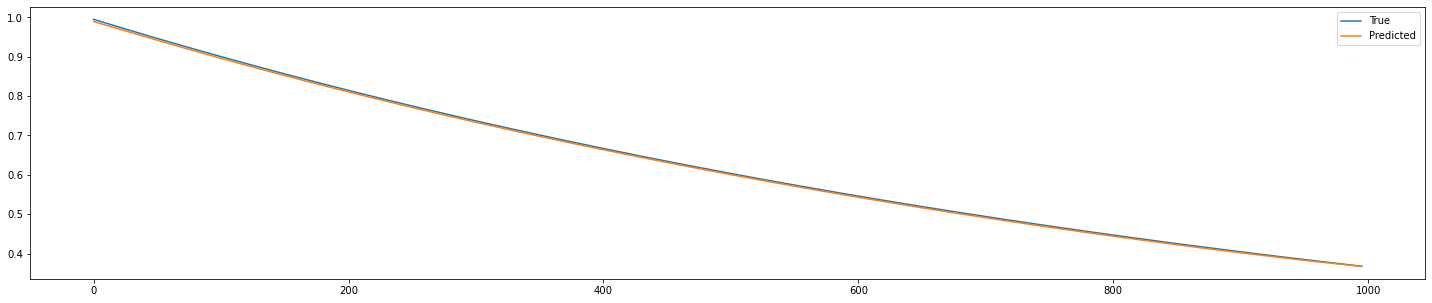

In [44]:
executeCNN_Lin("y2(t)=y2(t-1)*0.999", series2, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs)

Epoch 0 train loss:1.1188315153121948 test loss: 1.1199065446853638
Epoch 50 train loss:0.05354800075292587 test loss: 0.054832298308610916
Epoch 100 train loss:0.036082372069358826 test loss: 0.03691680356860161
Epoch 150 train loss:0.0027986650820821524 test loss: 0.002863427624106407
Epoch 200 train loss:0.008230303414165974 test loss: 0.00822728406637907
Epoch 250 train loss:0.005201447755098343 test loss: 0.00517065217718482


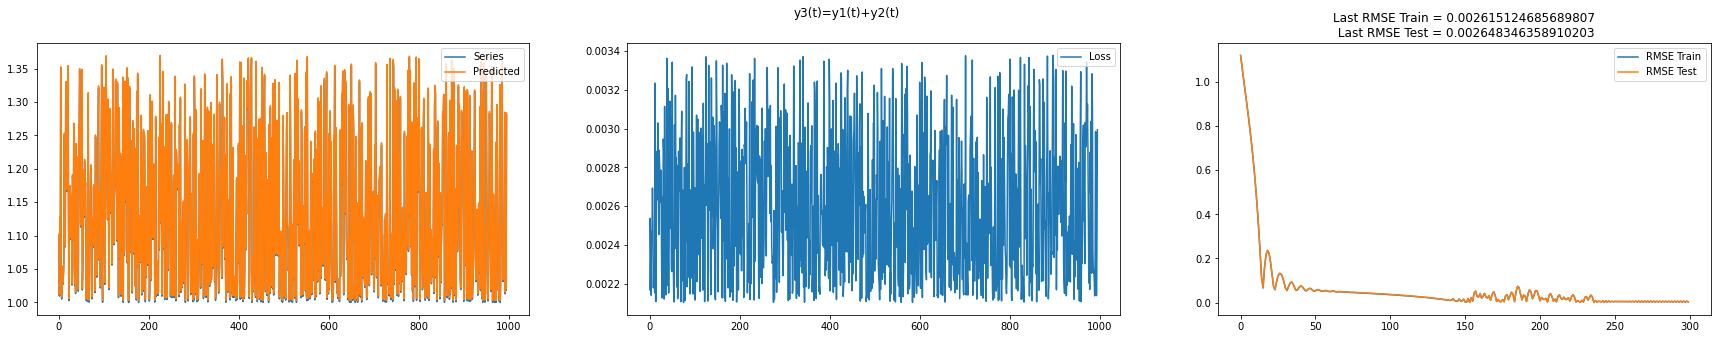

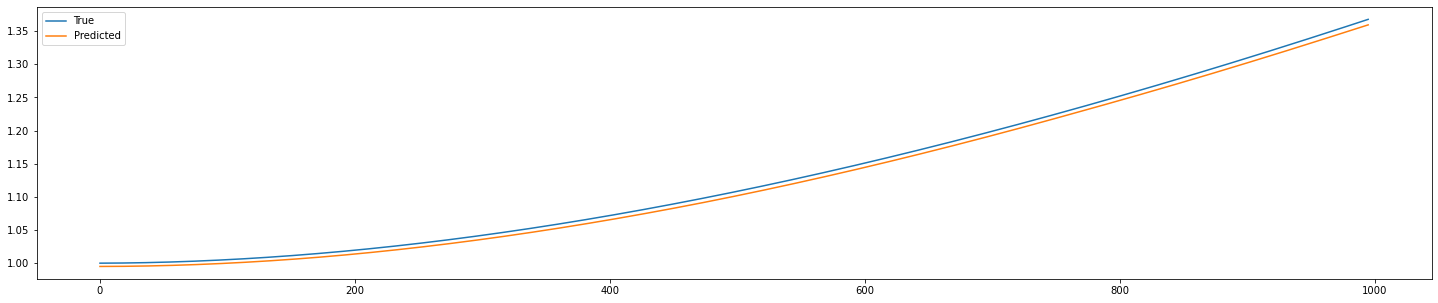

In [45]:
executeCNN_Lin("y3(t)=y1(t)+y2(t)", series3, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs)

Epoch 0 train loss:0.5862559080123901 test loss: 0.6022300720214844
Epoch 50 train loss:0.028372472152113914 test loss: 0.028936786577105522
Epoch 100 train loss:0.007794566452503204 test loss: 0.007831770926713943
Epoch 150 train loss:0.006992400623857975 test loss: 0.007139374036341906
Epoch 200 train loss:0.004717797040939331 test loss: 0.004719492979347706
Epoch 250 train loss:0.006320800166577101 test loss: 0.006470978260040283


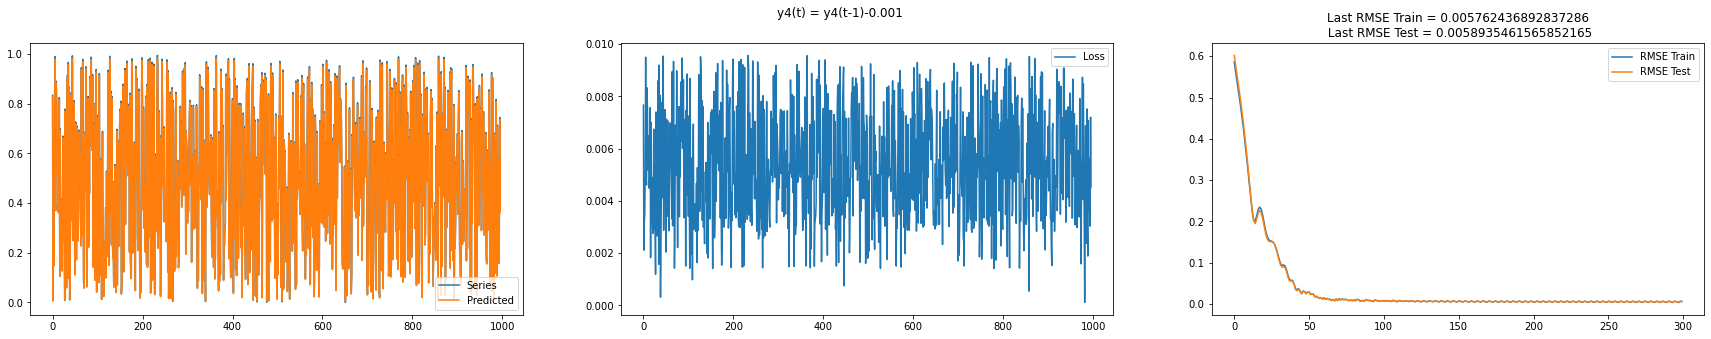

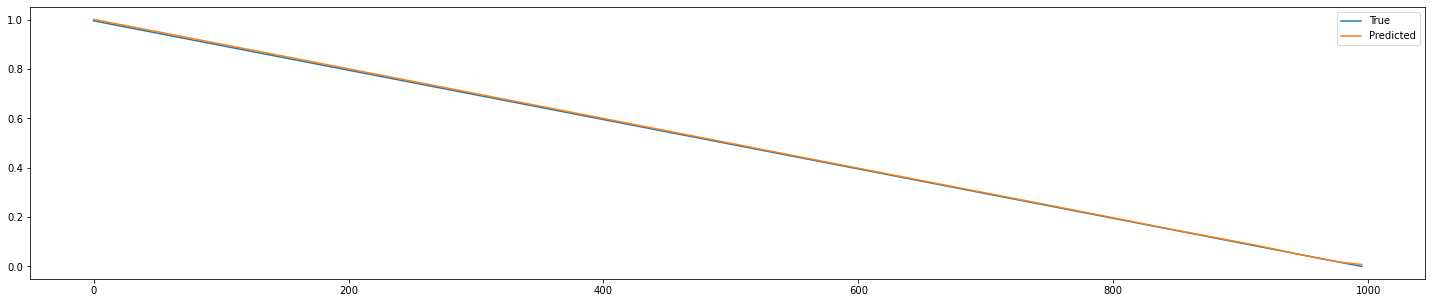

In [46]:
executeCNN_Lin("y4(t) = y4(t-1)-0.001", series4, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs)

Epoch 0 train loss:0.6276254057884216 test loss: 0.6272937655448914
Epoch 50 train loss:0.07212264835834503 test loss: 0.06880654394626617
Epoch 100 train loss:0.00787251815199852 test loss: 0.008371837437152863
Epoch 150 train loss:0.005564531777054071 test loss: 0.0056303334422409534
Epoch 200 train loss:0.005255659110844135 test loss: 0.005270539317280054
Epoch 250 train loss:0.004651406779885292 test loss: 0.004656998440623283


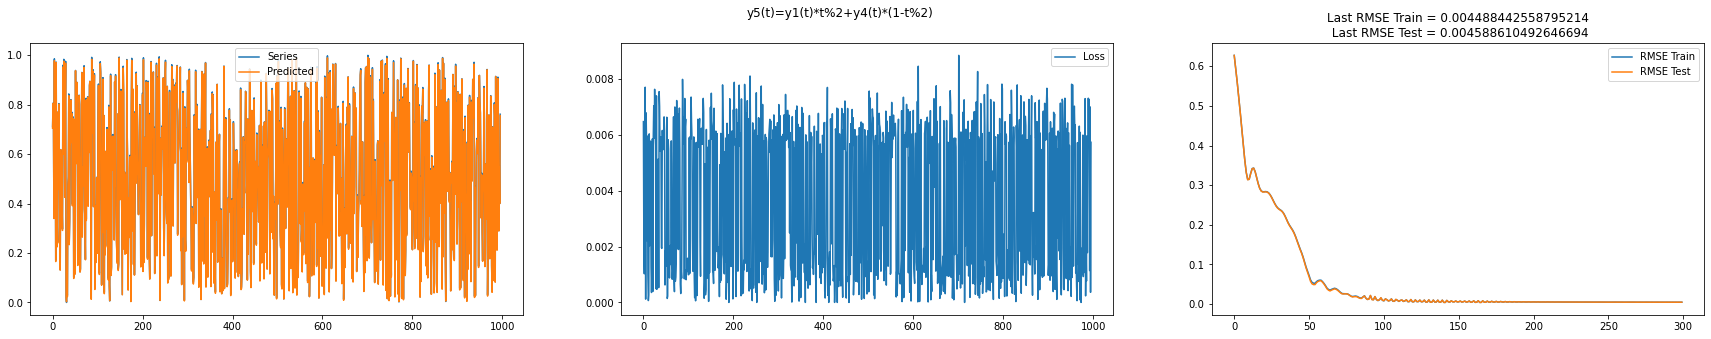

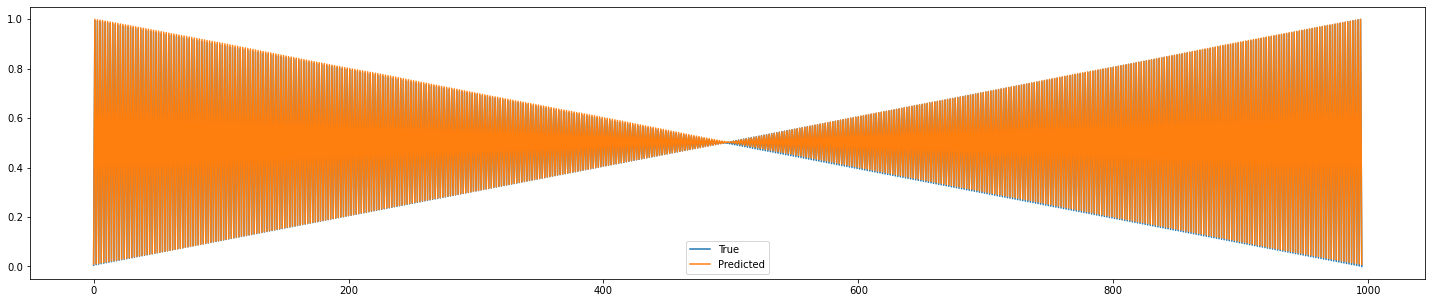

In [47]:
executeCNN_Lin("y5(t)=y1(t)*t%2+y4(t)*(1-t%2)", series5, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs)

Epoch 0 train loss:0.7341752648353577 test loss: 0.6361737251281738
Epoch 50 train loss:0.13911126554012299 test loss: 0.19119206070899963
Epoch 100 train loss:0.030720660462975502 test loss: 0.0315517857670784
Epoch 150 train loss:0.023795917630195618 test loss: 0.02275613136589527
Epoch 200 train loss:0.005020554643124342 test loss: 0.010916327126324177
Epoch 250 train loss:0.013265796937048435 test loss: 0.01558308769017458


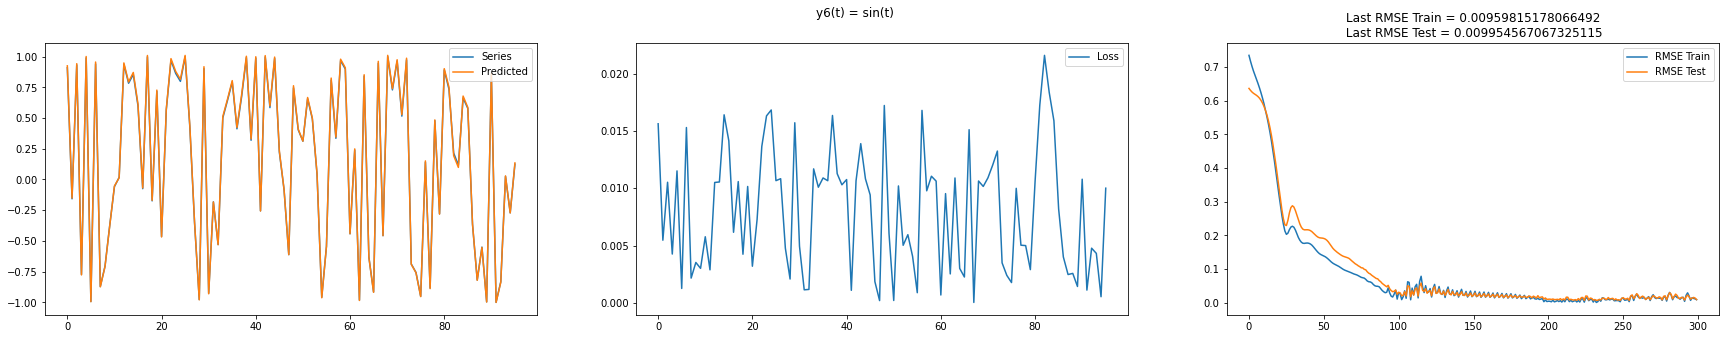

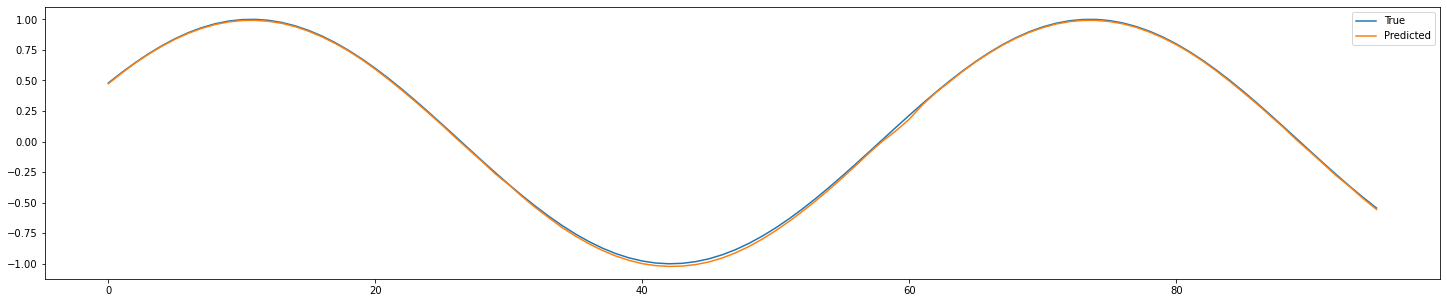

In [48]:
executeCNN_Lin("y6(t) = sin(t)", series6, feature_sequences=features_length, target_sequences=1, portion=portion_train_test, num_epochs=num_epochs)